# Modeling - Housing Price Prediction

## By: Nick Roller

## 1. Problem Statement:

Our client has asked us to produce a model to predict the expected price of a home given it's features, ammenities and attributes. As our dependant variable is continuous (dollar amount of home value) this will be a regression model. We will be exploring the following regression models, applying them to our dataset and determining the one that best suits our client's needs:
- Linear Regression
- Random Forest Regression
- Ridge Regression
- Lasso Regression

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from boruta import BorutaPy
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_rows', 500)

We first load our preprocessed data. As we can see, we have already one-hot encoded the categorical variables and scaled all continuous ones.

In [3]:
df = pd.read_csv('Data Files/final_features2.csv')
df.head()

,SalePrice,Remod_Age_Avg,GrLivArea,OverallQual,TotalBsmtSF,GarageArea,1stFlrSF,2ndFlrSF,BsmtFinSF1,LotArea,FullBath
0,208500,-1.058828,0.692021,0.762179,-0.393202,0.460518,-0.754347,1.344658,0.682376,-0.217666,0.875418
1,181500,0.125345,-0.376695,0.011878,0.679639,0.024408,0.478393,-0.786663,1.339277,0.078136,0.875418
2,223500,-0.993041,0.873321,0.762179,-0.224084,0.757865,-0.560023,1.374606,0.151058,0.502548,0.875418
3,250000,-0.927253,1.856159,1.512479,0.370470,1.887784,0.123145,1.841300,0.559207,1.276779,0.875418
4,307000,-1.124615,0.653853,1.512479,1.800044,0.896627,1.790077,-0.786663,2.283573,0.202631,0.875418


We have already computed our optimal features during feature selection, so we will drop everything but our 10 selected features

## 2. Splitting training and test data

In [4]:
#We first prepare our train and test data sets
y=df['SalePrice'].values
X=df.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [5]:
X_train.shape, X_test.shape

((909, 10), (228, 10))

In [6]:
y_train.shape, y_test.shape

((909,), (228,))

## 3. Model Selection

### A. Evaluate performance of the mean

#### We will first evaluate how well simply taking the mean does in predicting home value, this will give us a baseline to compare our models against.

In [7]:
train_mean = y_train.mean()
train_mean

170366.23872387237

In [8]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[170366.23872387]])

In [9]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387])

In [10]:
r2_score(y_train, y_tr_pred)

0.0

In [11]:
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_test, y_te_pred)

-0.004638575641743525

In [12]:
dumb_reg.predict(X_test)

array([170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 170366.23872387, 170366.23872387, 170366.23872387,
       170366.23872387, 1

##### R^2

In [13]:
r_mean = dumb_reg.score(X_test, y_test)
print(r_mean)

-0.004638575641743525


##### MAE

In [14]:
#MAE for dummy regression mean model
mae_mean = mean_absolute_error(y_test, y_te_pred)
mae_mean

46791.00450176595

##### MSE

In [15]:
#MSE for dummy regression mean model
mse_mean = mean_squared_error(y_test, y_te_pred)
mse_mean

3815549456.37617

### B. Linear Regression Model

In [16]:
#fit linear regression model and make prediction
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [17]:
#Print R^2
r2_score(y_test, y_pred)

0.8571516761146499

In [18]:
lr_mae = mean_absolute_error(y_test, y_pred)
lr_mae

16642.054826609998

In [19]:
lr_mse = mean_squared_error(y_test, y_pred)
lr_mse

542528286.0523554

In [20]:
(mae_mean-lr_mae)/mae_mean

0.6443321744464386

In [21]:
(mse_mean-lr_mse)/mse_mean

0.8578112294821036

Applying the basic lienar regression model has improved the prediction performance fairly significantly, MAE by 57% and MSE by 75% as we can see here.

#### Cross-Validation of linear model

In [22]:
#Importing CV score module and computing 5 fold scores

cv_scores = cross_val_score(reg, X, y, cv=5)

In [23]:
#Printing CV scores and their mean
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.84353269 0.86869497 0.8335336  0.85927119 0.83667147]
Average 5-Fold CV Score: 0.8483407823839239


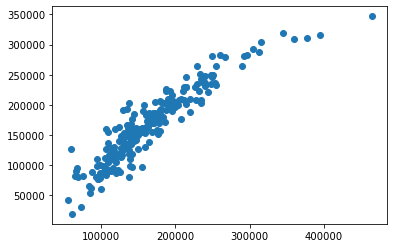

In [24]:
plt.scatter(y_test, y_pred)

In [25]:
reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

### C. Random Forest Model

#### Make Pipeline

In [26]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

#### Fit and assess using CV

In [27]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [28]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.86813148, 0.89092056, 0.89223645, 0.82896432, 0.85933732])

In [29]:
np.mean(rf_cv_scores)

0.8679180261512194

In [30]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.8679180261512194, 0.023287628423954515)

#### GridsearchCV

In [31]:
RF_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('randomforestregressor', RandomForestRegressor())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'randomforestregressor': RandomForestRegressor(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'mse',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_impurity_split': None,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_weight_fraction_leaf': 0.0,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__n_jobs': None,
 'randomforest

In [32]:
# Number of trees in random forest
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
#n_est = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [10]
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [False]

grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'randomforestregressor__max_depth': max_depth,
        'randomforestregressor__max_features': max_features,
        'randomforestregressor__min_samples_split':min_samples_split,
        'randomforestregressor__min_samples_leaf':min_samples_leaf,
        'randomforestregressor__bootstrap': bootstrap,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'randomforestregressor__max_depth': [10],
 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
 'randomforestregressor__min_samples_split': [5],
 'randomforestregressor__min_samples_leaf': [2],
 'randomforestregressor__bootstrap': [False],
 'standardscaler': [StandardScaler(), None]}

In [33]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [34]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__bootstrap': [False],
                         'randomforestregressor__max_depth': [10],
                         'randomforestregressor__max_features': ['auto', 'sqrt',
                                                                 'log2'],
                         'randomforestregressor__min_samples_leaf': [2],
                         'randomforestregressor__min_samples_split': [5],
                         'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143

In [35]:
rf_grid_cv.best_params_

{'randomforestregressor__bootstrap': False,
 'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': 'log2',
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 5,
 'randomforestregressor__n_estimators': 183,
 'standardscaler': StandardScaler()}

In [36]:
rf_grid_cv.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('standardscaler', StandardScaler()),
  ('randomforestregressor', RandomForestRegressor())],
 'estimator__verbose': False,
 'estimator__standardscaler': StandardScaler(),
 'estimator__randomforestregressor': RandomForestRegressor(),
 'estimator__standardscaler__copy': True,
 'estimator__standardscaler__with_mean': True,
 'estimator__standardscaler__with_std': True,
 'estimator__randomforestregressor__bootstrap': True,
 'estimator__randomforestregressor__ccp_alpha': 0.0,
 'estimator__randomforestregressor__criterion': 'mse',
 'estimator__randomforestregressor__max_depth': None,
 'estimator__randomforestregressor__max_features': 'auto',
 'estimator__randomforestregressor__max_leaf_nodes': None,
 'estimator__randomforestregressor__max_samples': None,
 'estimator__randomforestregressor__min_impurity_decrease': 0.0,
 'estimator__randomforestregressor__min_impurity_split': None,
 'estimator__randomforestregresso

In [37]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.87895201, 0.89470137, 0.90180052, 0.83095585, 0.86813595])

In [38]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8749091385096619, 0.02493588034092623)

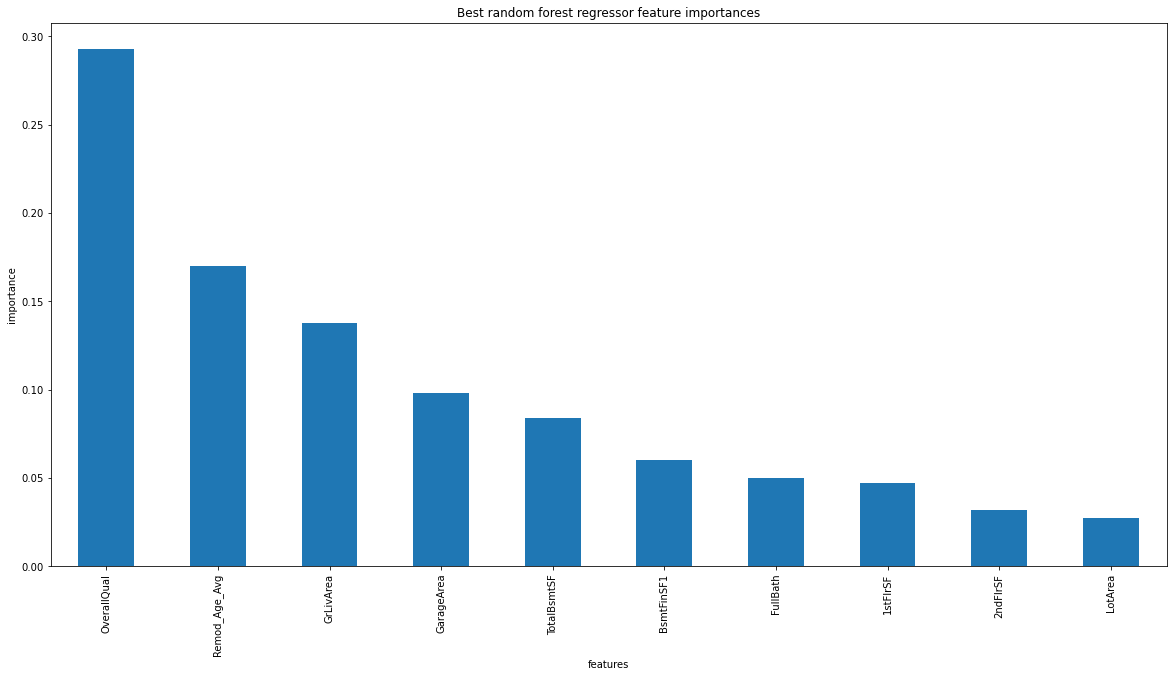

In [39]:
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [40]:
rf_feat_imps

OverallQual      0.292973
Remod_Age_Avg    0.169743
GrLivArea        0.137954
GarageArea       0.098005
TotalBsmtSF      0.084084
BsmtFinSF1       0.060388
FullBath         0.050226
1stFlrSF         0.047241
2ndFlrSF         0.032050
LotArea          0.027336
dtype: float64

### 3. Lasso Regression Model

In [41]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.4, normalize=True)
lasso.fit(X_train,y_train)

Lasso(alpha=0.4, normalize=True)

In [42]:
df_vars=df.drop('SalePrice',axis=1)
colnames = df_vars.columns

In [43]:
lasso_coef = lasso.coef_
pd.Series(lasso_coef, index=colnames).sort_values(ascending=False)

OverallQual      21808.720468
GrLivArea        21027.404125
BsmtFinSF1       10260.650897
GarageArea        6783.673893
TotalBsmtSF       6693.983745
LotArea           5750.495236
1stFlrSF           332.766119
2ndFlrSF             0.000000
FullBath         -2026.758802
Remod_Age_Avg   -14115.943915
dtype: float64

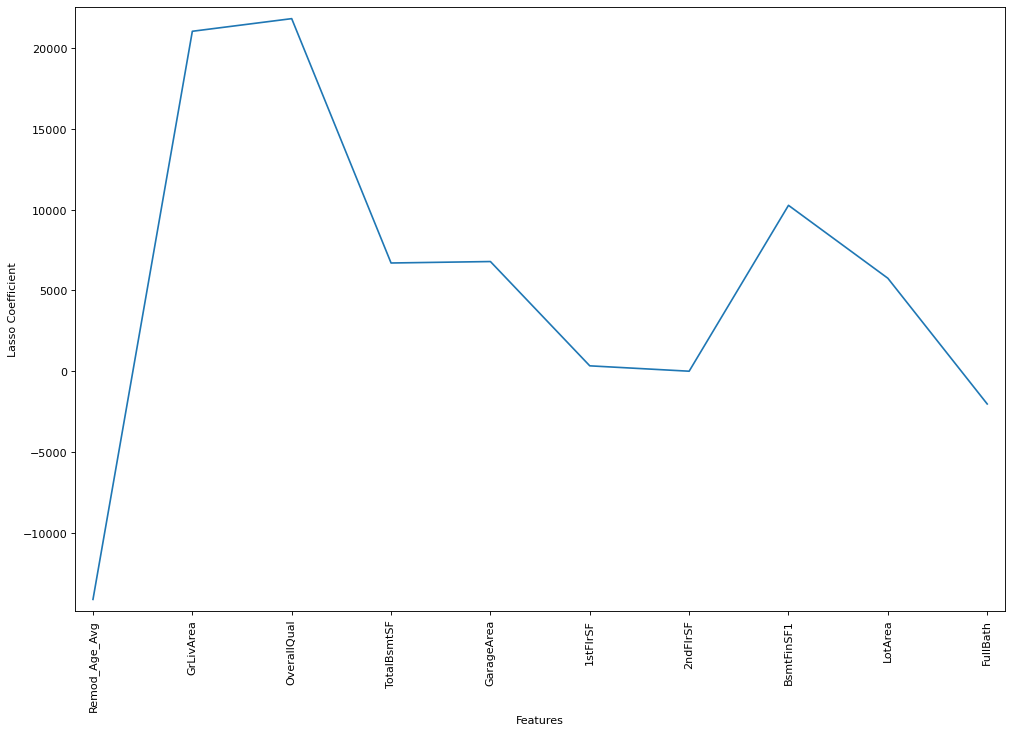

In [44]:
# Plot the coefficients
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)
plt.plot(range(len(colnames)), lasso_coef)
plt.xticks(range(len(colnames)), colnames.values, rotation=90) 
plt.margins(0.02)
plt.xlabel("Features")
plt.ylabel("Lasso Coefficient")
plt.show()

In [45]:
lasso.get_params()

{'alpha': 0.4,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

### 4. Ridge Regression Model

In [46]:
from sklearn.linear_model import Ridge

alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

ridge = Ridge(normalize=True)

In [47]:
for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10)
    ridge_scores.append(np.mean(ridge_cv_scores))
    ridge_scores_std.append(np.std(ridge_cv_scores))

In [48]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()


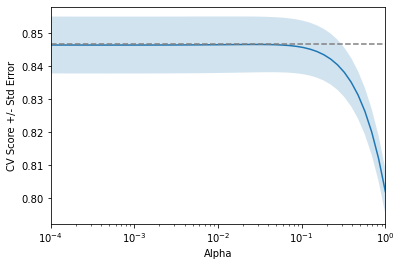

In [49]:
display_plot(ridge_scores, ridge_scores_std)

In [50]:
ridge=Ridge(normalize=True, alpha=0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

In [51]:
ridge.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

## 4. Model Performance

### Linear Regression Model

In [52]:
lr_neg_mae = cross_validate(reg, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [53]:
reg.score(X_train,y_train),reg.score(X_test,y_test)

(0.8554852505933639, 0.8571516761146499)

In [54]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(17946.44385088816, 1017.4956175348739)

In [55]:
mean_absolute_error(y_test, reg.predict(X_test))

16642.054826609998

### Random Forest Model

In [56]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [57]:
rf_grid_cv.score(X_train,y_train),rf_grid_cv.score(X_test,y_test)

(0.9822013961775701, 0.885139949455288)

In [58]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(15590.115549431506, 1001.8222270157482)

In [59]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

14547.424366166342

### Lasso Regression Model

In [60]:
lasso_neg_mae = cross_validate(lasso, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [61]:
lasso.score(X_train,y_train),lasso.score(X_test,y_test)

(0.8553561012750321, 0.8572174259455346)

In [62]:
lasso_mae_mean = np.mean(-1 * lasso_neg_mae['test_score'])
lasso_mae_std = np.std(-1 * lasso_neg_mae['test_score'])
lasso_mae_mean, lasso_mae_std

(17959.82877633373, 1032.8670950939857)

In [63]:
mean_absolute_error(y_test, lasso.predict(X_test))

16643.250780221355

### Ridge Regression Model

In [64]:
ridge_neg_mae = cross_validate(ridge, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.01, normalize=True)

In [65]:
ridge.score(X_train,y_train),ridge.score(X_test,y_test)

(0.8553575806378567, 0.8573231394153735)

In [66]:
ridge_mae_mean = np.mean(-1 * ridge_neg_mae['test_score'])
ridge_mae_std = np.std(-1 * ridge_neg_mae['test_score'])
ridge_mae_mean, ridge_mae_std

(17919.479256427316, 1033.1015041926414)

In [67]:
mean_absolute_error(y_test, ridge.predict(X_test))

16608.63970938545

## Conclusion

After having narrowed down our features to the top 10 in terms of feature importance, we then ran four different regression models to determine which was best for predicting a home's sale price. We ran a basic linear regression model in addition to random forest, lasso and ridge regression models. After using these models to predict on our test set with 5 fold cross validation, we have determined the Forest Regression model to be the preferred and best performing model. Based on our chosen our model, the four greatest predictors for a home's value is the general living area square footage, the exterior quality of the home, the size of the garage and the size of the basement. Our model have a mean absolute error of roughly 17,285 dollars, so it can predict a home's value +/- 8,643 dollars.